### Import Libraries

In [0]:

from keras.optimizers import Adam
from keras.datasets import cifar10
from keras.layers import Conv2D,LeakyReLU,BatchNormalization,Flatten,Dense,Reshape,Conv2DTranspose, Input
import matplotlib.pyplot as plt
from keras import initializers
from keras.models import Model
import numpy as np
from keras.utils import np_utils
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from skimage import transform
from scipy.linalg import sqrtm
from keras.models import model_from_json
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import TensorBoard
import tensorflow as tf

## RUN THE CELL BELOW TO LOAD 8 x 8 IMAGE GRID AND CALCULATE FID FOR 10K IMAGES

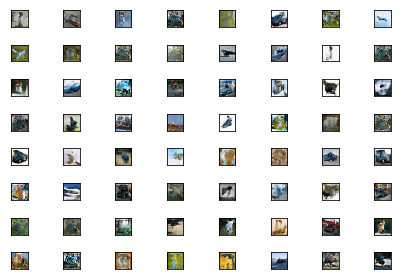

170500096/170498071 [==============================] - 2s 0us/step


87916544/87910968 [==============================] - 1s 0us/step
****fid ****43.8160099271499


In [3]:
# Load model by giving Json and h5 file

from keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Conv2D,LeakyReLU,BatchNormalization,Flatten,Dense,Reshape,Conv2DTranspose, Input
from skimage import transform
from scipy.linalg import sqrtm
from keras.models import model_from_json
import numpy as np

def load_model(JsonfileName,weightFileName):
    mJson = open(JsonfileName,'r')
    model_json = mJson.read()
    mJson.close()
    model = model_from_json(model_json)
    model.load_weights(weightFileName)
    return model
def calculate_fid(act1, act2):
    # calculate activations
    mu1, sigma1 = act1.mean(), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid
  
def resizeForInceptionV3(images1):
  imgList = list()
  for image in images1:
      newImage = transform.resize(image,(299,299,3))
      imgList.append(newImage)
  return np.asarray(imgList)  



'''LOAD MODEL'''
generator = load_model('generatorDCFinal.json','generatorDCFinal .h5')
samples = 64
latent_dim = 100
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

for k in range(samples):
    plt.subplot(8, 8, k + 1, xticks=[], yticks=[])
    plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

plt.tight_layout()
plt.show()

'''Calculate FID for 10k images'''
print('Calculating FID please wait..')
resizedReal = []
resizedFake = []
samples = 10000
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
inceptionModel = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))
for size in range(len(xTest)//250):
  images1 = resizeForInceptionV3(x_fake[size*250:(size+1)*250])
  images2 = resizeForInceptionV3(xTest[size*250:(size+1)*250])
  act1 = inceptionModel.predict(images1)
  act2 = inceptionModel.predict(images2)
  for act in act1:
    resizedReal.append(act)
  for act in act2:
    resizedFake.append(act)
fid = calculate_fid(np.asarray(resizedReal),np.asarray(resizedFake))
print('****fid ****'+str(fid))

#### Mount Google Drive to save generated results

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Define Discriminator

In [0]:
'''BUILD DISCRIMINATOR  '''
'''Consists of 4 Convolution layers starting from dimension 64 till 512 and 1 Dense layer for output'''

def get_discriminator(inp_dim):
    discriminator = Sequential()
    #1
    discriminator.add(Conv2D(64,kernel_size=5,strides=2,input_shape =  inp_dim))
    discriminator.add(LeakyReLU(0.2))
    #2
    discriminator.add(Conv2D(128,kernel_size=5,strides=2,padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    #3
    discriminator.add(Conv2D(256,kernel_size=5,strides=2,padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    #4
    discriminator.add(Conv2D(512,kernel_size=5,strides=2,padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    #Flatten
    discriminator.add(Flatten())
    #Output
    discriminator.add(Dense(1, activation='sigmoid'))
    return discriminator

### Define Generator

In [0]:
'''BUILD GENERATOR  '''
'''Consists of 4 Convolution2D Transpose  layers starting from dimension 256 till 3
and 1 Dense layer'''

def get_generator(latent_dim):
    generator = Sequential()
    # foundation for 4x4 image
    n_nodes = 512 * 2 * 2
    generator.add(Dense(n_nodes, input_shape=(latent_dim,)))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Reshape((2, 2, 512)))
    # upsample to 8x8
    generator.add(Conv2DTranspose(256,kernel_size=3, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    generator.add(Conv2DTranspose(64,kernel_size=3, strides= 2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))
    # output layer
    generator.add(Conv2DTranspose(3, (3,3), strides= 2, activation='tanh', padding='same'))
    return generator


### Define Combined Model

In [0]:
def define_gan(generator, discriminator,latent_dim):
    discriminator.trainable = False
    
    #Noise generation
    z = Input(shape=(latent_dim,))
    
    #Give noise input to generator to predict image
    img = generator(z)
    
    #Pass generated image to discriminator
    decision = discriminator(img)
    
    #Compile model and return
    d_g = Model(inputs=z, outputs=decision)
    d_g.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                metrics=['binary_accuracy'])
    return d_g

### Download Data set and build discriminator, generator and combined model

In [0]:
#Download CIFAR10 Dataset

(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()

#Specify input dimensions
inp_dim = xTrain[0].shape
xTrain = xTrain.astype('float32')

#Normalize
xTrain = (xTrain-127.5)/127.5

#Build discriminator
discriminator = get_discriminator(inp_dim)

#Build generator
generator = get_generator(100)
latent_dim = 100

#Compile discriminator
discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])
#Combined model
gan = define_gan(generator,discriminator,latent_dim)

### Function to calculate FID

In [0]:
def calculate_fid(act1, act2):
  
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(), np.cov(act2, rowvar=False)
    
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### Function to resize images for FID calculation

In [0]:
def resizeForInceptionV3(images1):
  #Declare empty list to store images
  imgList = list()
  
  #Resize each incoming image and add to list
  for image in images1:
      newImage = transform.resize(image,(299,299,3))
      imgList.append(newImage)
  return np.asarray(imgList)

### Function to save model

In [0]:
#Save model architecture as Json and weights as h5 file

def save_model(model,JsonfileName,weightFileName):
  model_json = model.to_json()
  with open('/content/drive/My Drive/DLProject1/'+JsonfileName,'w') as json_file:
    json_file.write(model_json)
  model.save_weights('/content/drive/My Drive/DLProject1/'+weightFileName)


### Function to load model

In [0]:
# Load model by giving Json and h5 file

def load_model(JsonfileName,weightFileName):
  mJson = open(JsonfileName,'r')
  model_json = mJson.read()
  mJson.close()
  model = model_from_json(model_json)
  model.load_weights(weightFileName)
  return model

In [0]:
'LOAD MODEL'

# generator = load_model('/content/drive/My Drive/DLProject1/generatorDC.json','/content/drive/My Drive/DLProject1/generatorDC.h5')
# gan = load_model('/content/drive/My Drive/DLProject1/ganDC.json','/content/drive/My Drive/DLProject1/ganDC.h5')
# discriminator = load_model('/content/drive/My Drive/DLProject1/discriminatorDC.json','/content/drive/My Drive/DLProject1/discriminatorDC.h5')


### Declare TensorBoard

In [0]:
#Declare tensorboard object

tensorboard = TensorBoard(
  log_dir='/content/drive/My Drive/DLProject1/DCLogs2',
  histogram_freq=0,
  batch_size=64,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(gan)

### Train Model

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


 Epoch = 0 dLoss =0.03532717004418373 gLoss = 1.3545198


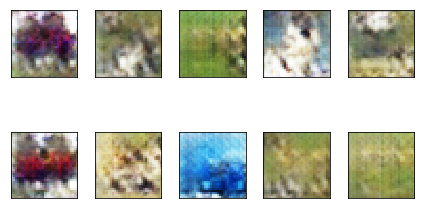

 Epoch = 1 dLoss =0.06278066337108612 gLoss = 0.44787857


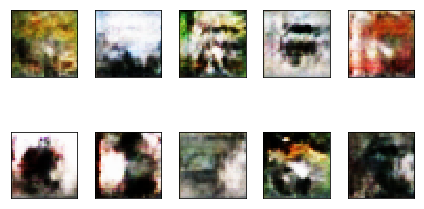

 Epoch = 2 dLoss =0.0835399255156517 gLoss = 3.8058264


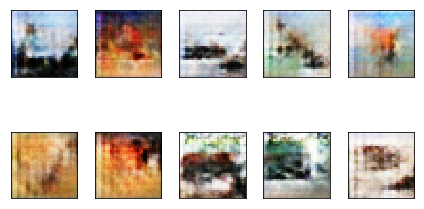

 Epoch = 3 dLoss =0.09374233335256577 gLoss = 4.891568
 Epoch = 4 dLoss =0.07077495753765106 gLoss = 10.962472


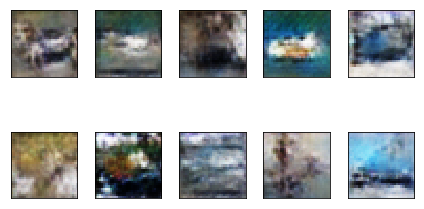

 Epoch = 5 dLoss =0.09611412137746811 gLoss = 3.1931994


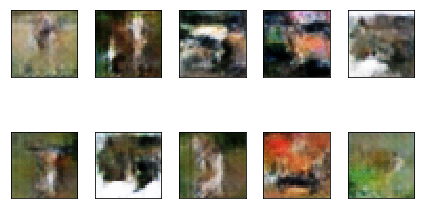

 Epoch = 6 dLoss =0.13000652194023132 gLoss = 3.8214657


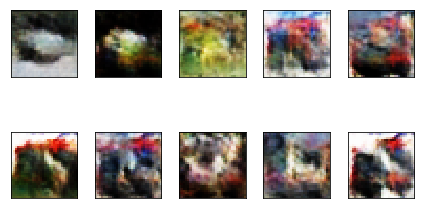

 Epoch = 7 dLoss =0.024468785151839256 gLoss = 10.291383


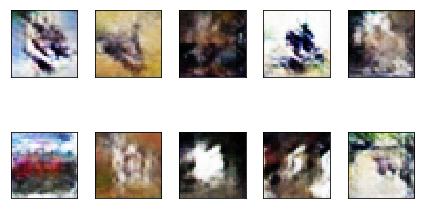

 Epoch = 8 dLoss =0.022686857730150223 gLoss = 12.058763
 Epoch = 9 dLoss =0.008590861223638058 gLoss = 7.5046716


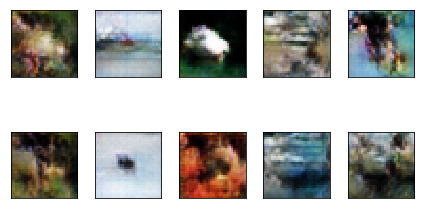

 Epoch = 10 dLoss =0.10351449251174927 gLoss = 4.476411


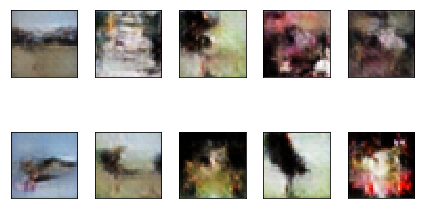

 Epoch = 11 dLoss =0.11406567692756653 gLoss = 5.355915


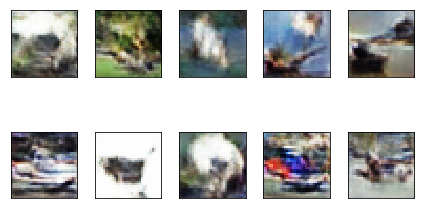

 Epoch = 12 dLoss =0.05956239998340607 gLoss = 5.4961953
 Epoch = 13 dLoss =0.04663742706179619 gLoss = 13.07138


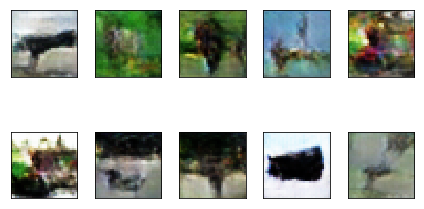

 Epoch = 14 dLoss =0.007067332975566387 gLoss = 3.8042095


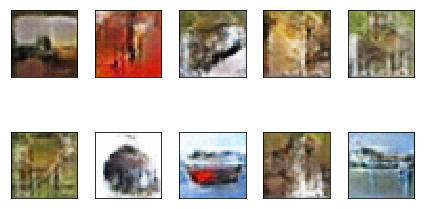

 Epoch = 15 dLoss =0.029585324227809906 gLoss = 5.1211286


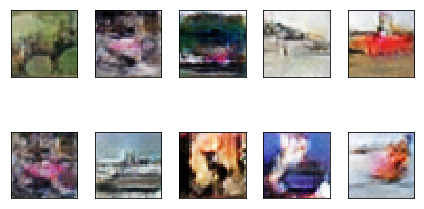

 Epoch = 16 dLoss =0.015768596902489662 gLoss = 4.192045


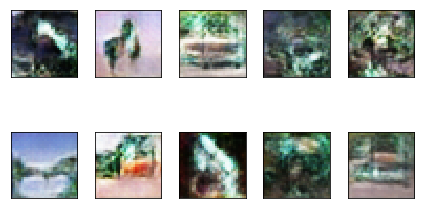

 Epoch = 17 dLoss =0.08676481246948242 gLoss = 4.1439404
 Epoch = 18 dLoss =0.013585299253463745 gLoss = 5.2722306


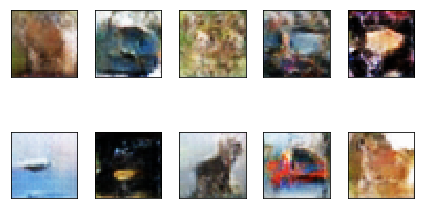

 Epoch = 19 dLoss =0.05487419664859772 gLoss = 3.3147295


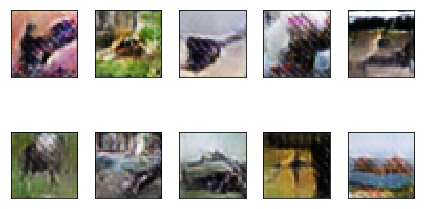

 Epoch = 20 dLoss =0.007893688976764679 gLoss = 5.2366734


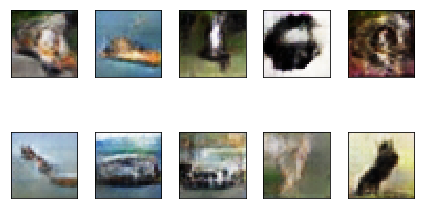

 Epoch = 21 dLoss =0.022514594718813896 gLoss = 8.5513735
 Epoch = 22 dLoss =0.2282143086194992 gLoss = 7.503027


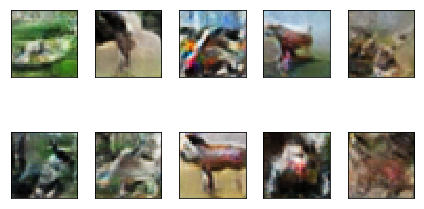

 Epoch = 23 dLoss =0.02483823150396347 gLoss = 4.0248394


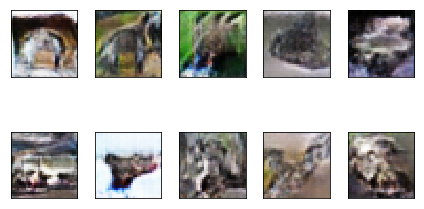

 Epoch = 24 dLoss =0.019087735563516617 gLoss = 5.7387314


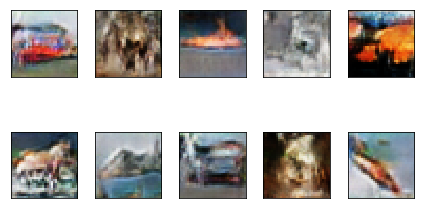

 Epoch = 25 dLoss =0.008363358676433563 gLoss = 5.905213


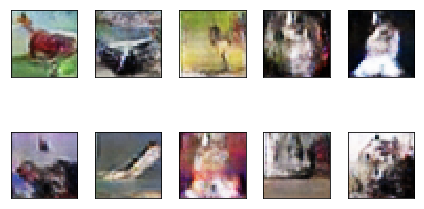

 Epoch = 26 dLoss =0.2563433051109314 gLoss = 10.777817
 Epoch = 27 dLoss =0.0190944354981184 gLoss = 4.5654426


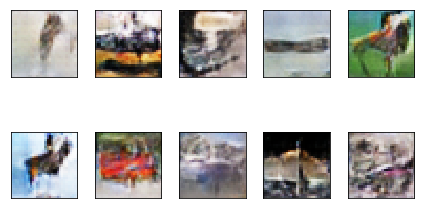

 Epoch = 28 dLoss =0.044190604239702225 gLoss = 5.8826823


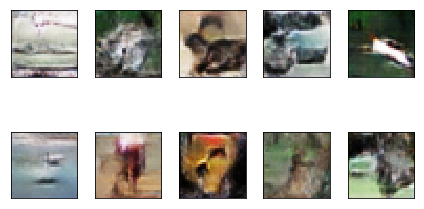

 Epoch = 29 dLoss =0.1951436847448349 gLoss = 9.037533


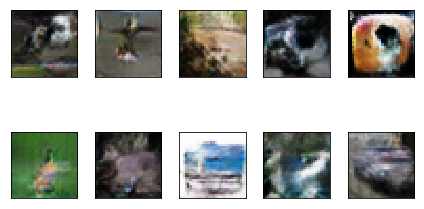

 Epoch = 30 dLoss =0.03720128536224365 gLoss = 5.774677


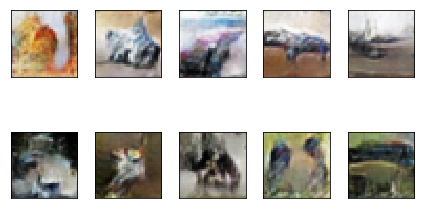

 Epoch = 31 dLoss =0.013821255415678024 gLoss = 5.548236
 Epoch = 32 dLoss =0.01221473328769207 gLoss = 7.0973425


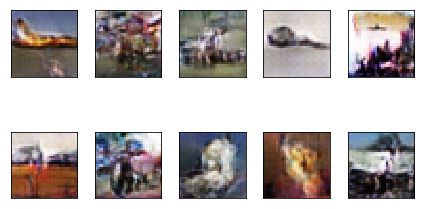

 Epoch = 33 dLoss =0.0067026494070887566 gLoss = 5.283065


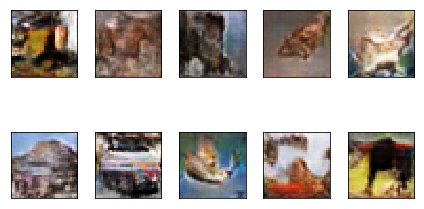

 Epoch = 34 dLoss =0.020276302471756935 gLoss = 6.1528125


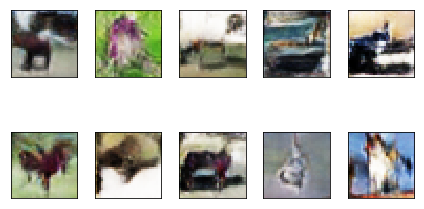

 Epoch = 35 dLoss =0.014024441130459309 gLoss = 6.1867085
 Epoch = 36 dLoss =0.0026852539740502834 gLoss = 10.665459


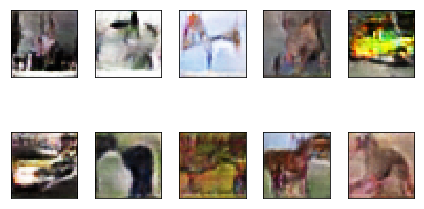

 Epoch = 37 dLoss =0.003973368555307388 gLoss = 6.3818426


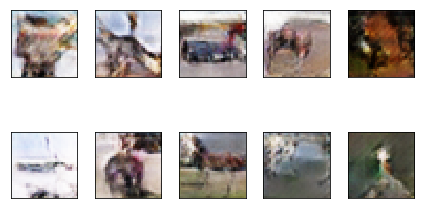

 Epoch = 38 dLoss =0.11175186932086945 gLoss = 5.0228376


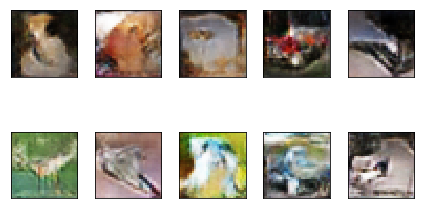

 Epoch = 39 dLoss =0.00825746450573206 gLoss = 5.8503475


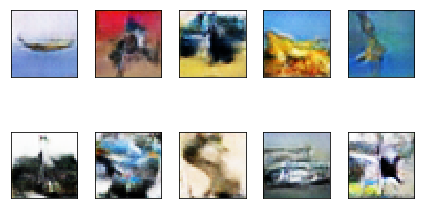

 Epoch = 40 dLoss =0.008398471400141716 gLoss = 8.92048
 Epoch = 41 dLoss =0.11476492881774902 gLoss = 6.046834


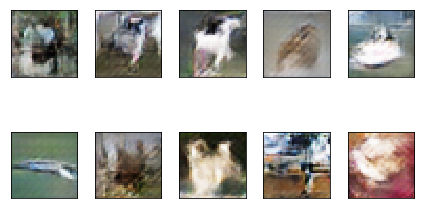

 Epoch = 42 dLoss =0.07896646857261658 gLoss = 6.5188856


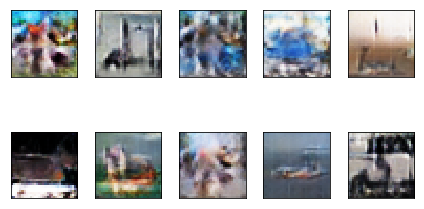

 Epoch = 43 dLoss =0.012001873925328255 gLoss = 6.092


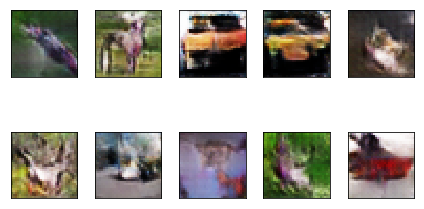

 Epoch = 44 dLoss =0.0010870328405871987 gLoss = 7.992108
 Epoch = 45 dLoss =0.002570284530520439 gLoss = 6.327654


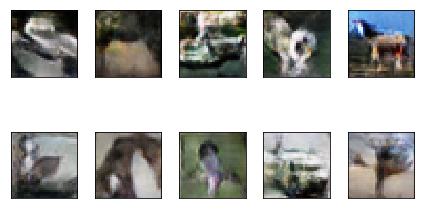

 Epoch = 46 dLoss =0.15685895085334778 gLoss = 4.8434625


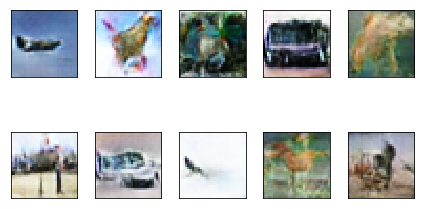

 Epoch = 47 dLoss =0.010766638442873955 gLoss = 5.4981437


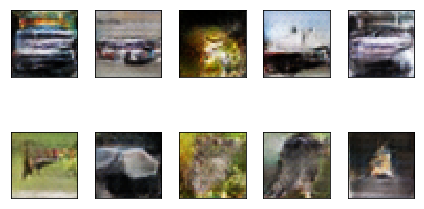

 Epoch = 48 dLoss =0.002233227016404271 gLoss = 7.0204906


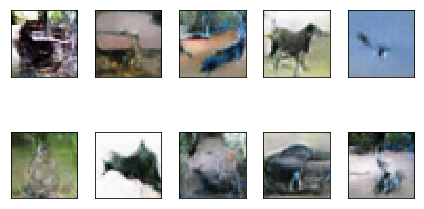

 Epoch = 49 dLoss =0.5809125900268555 gLoss = 14.601507
 Epoch = 50 dLoss =0.007681455463171005 gLoss = 5.9316454


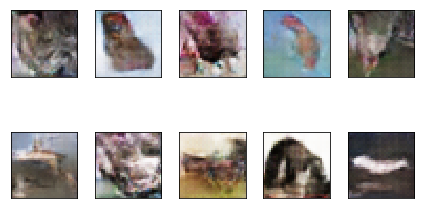

 Epoch = 51 dLoss =0.0054353876039385796 gLoss = 14.90606


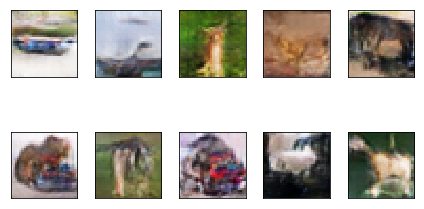

 Epoch = 52 dLoss =0.1453319489955902 gLoss = 9.867332


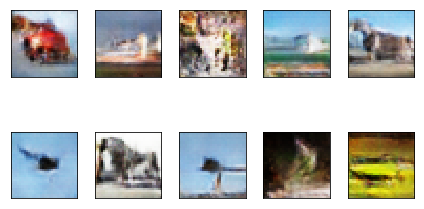

 Epoch = 53 dLoss =0.002646590117365122 gLoss = 6.124678
 Epoch = 54 dLoss =0.031201552599668503 gLoss = 4.6800566


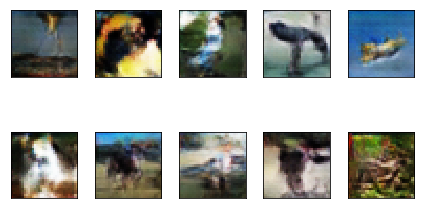

 Epoch = 55 dLoss =0.0023020391818135977 gLoss = 8.573854


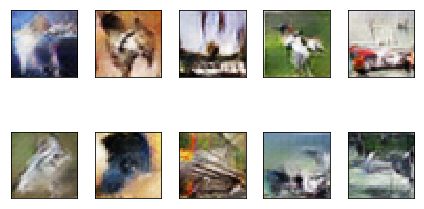

 Epoch = 56 dLoss =0.061832379549741745 gLoss = 6.4374413


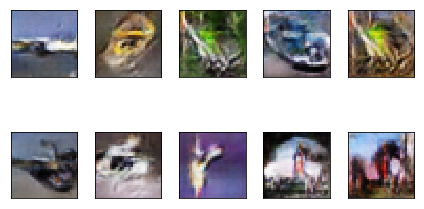

 Epoch = 57 dLoss =0.012202431447803974 gLoss = 5.7417183


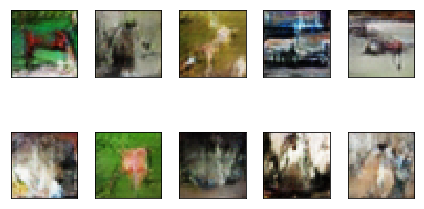

 Epoch = 58 dLoss =0.11663088202476501 gLoss = 8.504319
 Epoch = 59 dLoss =0.001594281056895852 gLoss = 8.525003


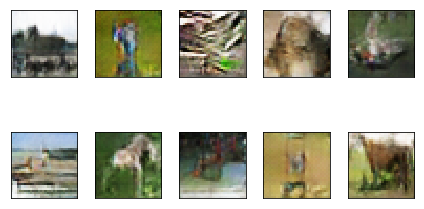

 Epoch = 60 dLoss =0.007227407768368721 gLoss = 6.8714843


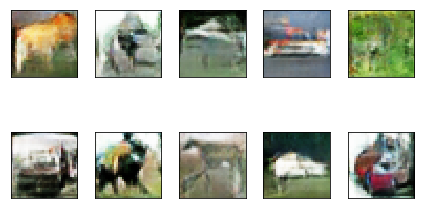

 Epoch = 61 dLoss =0.14396339654922485 gLoss = 9.132545


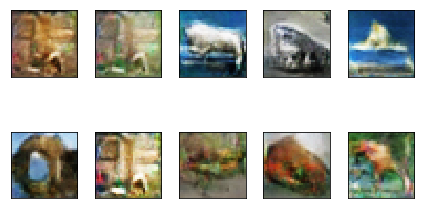

 Epoch = 62 dLoss =0.0014579633716493845 gLoss = 8.493911


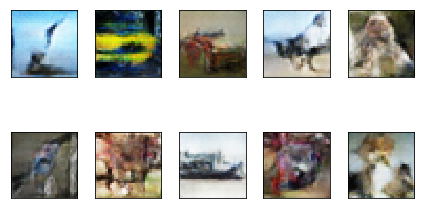

 Epoch = 63 dLoss =0.053194619715213776 gLoss = 13.191463
 Epoch = 64 dLoss =0.039042748510837555 gLoss = 14.933489


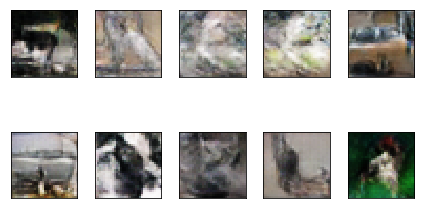

 Epoch = 65 dLoss =0.004494226071983576 gLoss = 5.3234835


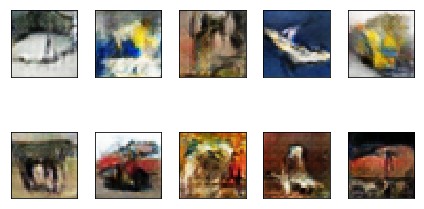

 Epoch = 66 dLoss =0.0076921540312469006 gLoss = 6.3175325


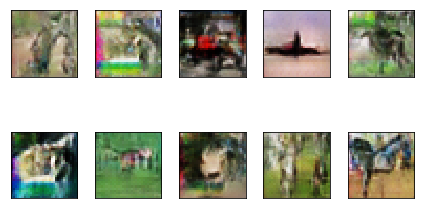

 Epoch = 67 dLoss =5.296325866765983e-07 gLoss = 16.118095
 Epoch = 68 dLoss =2.437153625578503e-07 gLoss = 16.118095


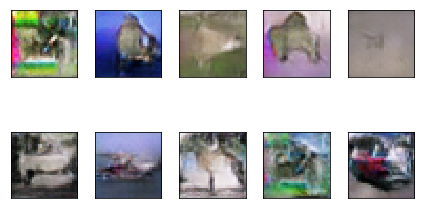

 Epoch = 69 dLoss =0.0030485147144645452 gLoss = 7.468274


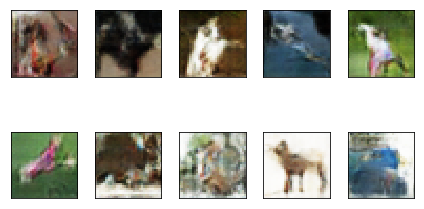

 Epoch = 70 dLoss =0.0006125604850240052 gLoss = 9.01218


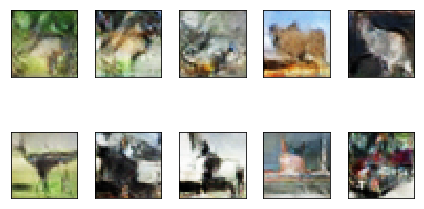

 Epoch = 71 dLoss =0.0009890682995319366 gLoss = 7.7558594


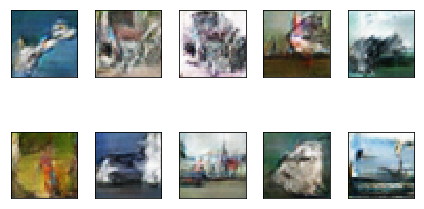

 Epoch = 72 dLoss =0.003322537988424301 gLoss = 5.939771
 Epoch = 73 dLoss =0.11948207020759583 gLoss = 7.1853437


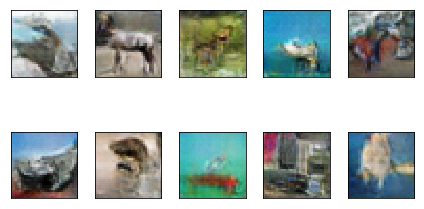

 Epoch = 74 dLoss =0.010476122610270977 gLoss = 6.8693004


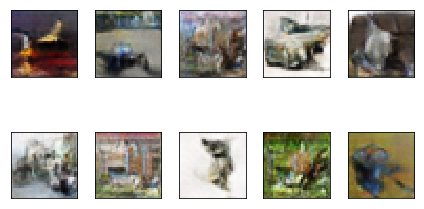

 Epoch = 75 dLoss =0.0014121229760348797 gLoss = 12.043446


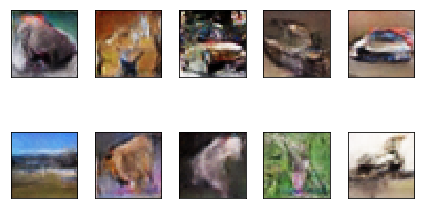

 Epoch = 76 dLoss =0.021178696304559708 gLoss = 6.9738617
 Epoch = 77 dLoss =0.02955184131860733 gLoss = 5.8331513


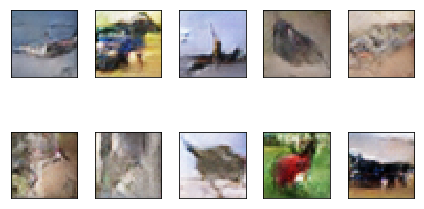

 Epoch = 78 dLoss =0.004167690873146057 gLoss = 8.121931


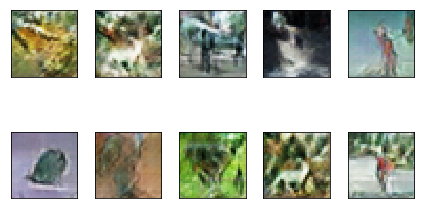

 Epoch = 79 dLoss =0.01695491001009941 gLoss = 7.2837033


In [0]:
#Train from scratch

#Declare batch size
batch_size = 64

smooth = 0.1

#Declare real/true labels[ALL ones]
real = np.ones(shape=(batch_size, 1))

#Declare real/true labels[ALL Zeros]
fake = np.zeros(shape=(batch_size, 1))

#Declare epoch
epoch = 100
fidL = []
dLoss = []
gLoss = []
fidCounter = 0

# Declare inceptionModel for calculating FID
inceptionModel = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

gan  = define_gan(generator,discriminator,latent_dim=latent_dim)
for i in range(0,epoch):
  for j in range(len(xTrain) // batch_size): # Each epoch has 781 iterations
    discriminator.trainable = False
    
    # Train on Real
    X_batch = xTrain[j*batch_size:(j+1)*batch_size]
    dLossReal = discriminator.train_on_batch(X_batch,real)
    
    #Fake
    z = np.random.normal(loc = 0,scale = 1,size = (batch_size,latent_dim))
    X_fake = generator.predict_on_batch(z)
    dLossFake = discriminator.train_on_batch(x=X_fake,y=fake)
    
    #Discriminator
    d_loss =  0.5 * (dLossReal[0] + dLossFake[0])
    discriminator.trainable = False
    g_loss = gan.train_on_batch(x=z, y=real)
    
    '''THIS CODE CALCULATES FID FOR 10K IMAGES'''
    
    #fidCounter=fidCounter+1;
    #print(' j '+str(j)+ ' dLoss '+str(d_loss)+' gLoss '+str(g_loss[0]))
#     if fidCounter == 1000:
#       fidCounter = 1
#       print('IN FID ')
#       resizedReal = []
#       resizedFake = []
#       samples = 10000
#       x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))
#       for size in range(len(xTest)//250):
# #       for size in range(0,1):
#         images1 = resizeForInceptionV3(x_fake[size*250:(size+1)*250])
#         #resizedFake.append(images1)
#         images2 = resizeForInceptionV3(xTest[size*250:(size+1)*250])
#         act1 = inceptionModel.predict(images1)
#         act2 = inceptionModel.predict(images2)
#         for act in act1:
#           resizedReal.append(act)
#         for act in act2:
#           resizedFake.append(act)
#       fid = calculate_fid(np.asarray(resizedReal),np.asarray(resizedFake))
#       print('****fid ****'+str(fid))
#       tensorboard.on_epoch_end(j,{"fid":fid}) 
#       fidL.append(str(fid))

      #PLOT images to check progress
    if j % 1000 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))
          
        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()
        tensorboard.on_epoch_end(j, {"D_real_loss":dLossReal[0] ,"D_fake_loss":dLossFake[0],"GAN_loss":g_loss[0]}) 
        write_log(tensorboard,["D_real_acc","D_real_loss","D_fake_acc","D_fake_loss"],[dLossReal[1],dLossReal[0],dLossFake[1],dLossFake[0]],j)
  #print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (i, epoch, d_loss[-1], g_loss[-1]), 100*' ')
  print(' Epoch = '+str(i)+ ' dLoss ='+str(d_loss)+' gLoss = '+str(g_loss[0]))
  
  #Save model after every epoch
  save_model(generator,'generatorDC.json','generatorDC.h5')
  save_model(discriminator,'discriminatorDC.json','discriminatorDC.h5')
  save_model(gan,'ganDC.json','ganDC.h5')
  

